In [185]:
from lxml import html
from time import sleep
import time
from random import randint
import os
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import scipy as sc
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


#### Due to EBay blocking crawling after 5 first pages of products. We had to think about a creative way to overcome this problem.
#### We decided to sort all laptops according to price. Dividing the laptops according price range. So we get only 5 pages as they are the first ones in their price range.

In [143]:
def Filter_Results(Min_price , Max_price , Page) :
    url = "https://www.ebay.com/sch/i.html?_from=R40&_nkw=laptop&_sacat=0&rt=nc&_udlo=" + str(Min_price) + "&_udhi=" + str(Max_price)+ "&_pgn=" + str(Page)
    return url

#### In order to divide all pages to groups according price ranges, we gathered all pages links in a list.

In [144]:
def Get_All_Url_Pages() : ## 124 pages
    UrlArray = []
    for i in range(800,10000,300) :
        for j in range(1,5) :
            UrlArray.append(Filter_Results(i,i+300,j))
    return UrlArray

#### We gathered all computers links in a single page(by link) in a list.

In [145]:
def All_Computer_Urls_In_Page(url): 
    UrlArray = []
    html = requests.get(url)
    soup = BeautifulSoup(html.content,'html.parser')
    
    for i in soup.findAll('a',attrs ={"class" : "s-item__link"}):
        UrlArray.append(i["href"])
    if len(UrlArray) == 0 :
        return UrlArray
    UrlArray.pop(0)
    return UrlArray

#### Crawling data of a single product by link

In [146]:
def Single_Product_Crawling(url):
    Data_Arr=[]
    html = requests.get(url)
    soup = BeautifulSoup(html.content,'html.parser')
    table= soup("div",attrs={"class":"ux-layout-section__item ux-layout-section__item--table-view"})[0]
    labels_Arr=table.findAll("div",attrs={"class":"ux-labels-values__labels"})
    var=table.findAll("div",attrs={"class":"ux-labels-values__values"})
    Lab=[]
    feat=[]
    for row in labels_Arr:
        Lab.append(row.find("span",attrs={"class":"ux-textspans"}).get_text().replace(":", "" ))
    for row in var:
        feat.append(row.find("span",attrs={"class":"ux-textspans"}).get_text())
   
    Lab.append('Price')
    feat.append(get_laptop_price(url))
    
    res = {}
    for key in Lab:
        for value in feat:
            res[key] = value
            feat.remove(value)
            break
    return res

#### Crawling of the price data

In [147]:
def get_laptop_price(url):
    html = requests.get(url)
    soup = BeautifulSoup(html.content,'html.parser')
    price = soup.find("span" , attrs = {"class" : "ux-textspans ux-textspans--SECONDARY ux-textspans--BOLD"})
    if price is None :
        return np.nan
    return price.get_text()


    

#### We started with a first row in order to avoid edge cases

In [148]:
def First_Row_dataframe(url):
    
    arr = Single_Product_Crawling(url)
    df = pd.DataFrame(arr,index =[0])      
        
    return df


#### We append the dataframe by 1 row, representing a new product data.

In [149]:
def Append_DataFrame(features,Main_DF) :
    size = Main_DF.shape[0]
    df = pd.DataFrame(features,index = [size]) 
    Main_DF = Main_DF.append(df)

    return Main_DF

#### The main function of crawling, that runs on list of all computers, from page 0 to 120(all of our laptops) with jumps of 5 pages. 
#### Every 5 pages we made a dataframe, and at the end, we combined all the dataframes.

#### We did it this way, because the time for crawling took 2 days, and it was stopped due to technical issues as electricity shuts, internet disconnections or EBay protocol blocks.

In [150]:
def Main() :
    
    First_Row_Url = "https://www.ebay.com/itm/254310867213?hash=item3b361be10d:g:3uIAAOSwmgteKfQa&amdata=enc%3AAQAHAAAA4JjT2DOOOgNiLO4PQz84tk6qsTIf3k%2BW%2F1rjqUrcoKjMIsB46S96w9%2Bvm%2Bqn%2F8i5mmfrU6EpLrLRTsMxWOSEa9ydhldxcpUt2Fr2FpHwShGJy5fduGbsrucSwhMnD0YhN6bWN58RjQ%2BADPTkoX9c2WPYYxsrPSgIDntp%2BNX93N41iHHl2Uo2DDxpFOw5iejPTitd6OVld6ke3osglR6%2FyqkaUwUb0%2Fep%2BZbM%2BltTUC6E3xDcnLXxcdeJrE1T5RsmpPzTqvqOa4W59JoY9q8OzghVD9y55%2B50mbkycWiRFvFh%7Ctkp%3ABFBMwJr_5rZh"
    Main_DF = First_Row_dataframe(First_Row_Url)
    
    All_Pages = Get_All_Url_Pages()
    for i in range(0,120,5):
        first=i
        last=i+4
        Main_DFi=Main_DF.copy()
        Page_Url = All_Pages[i]
        Page_Links_Url = All_Computer_Urls_In_Page(Page_Url)
        for j in Page_Links_Url :
            Main_DF = Append_DataFrame(Single_Product_Crawling(j),Main_DF)
            #sleep(1)
        DataFrame_to_csv(Main_DF,first,last)
        
    return Main_DF

In [151]:
def DataFrame_to_csv(Main_DF,first,last) :
    
    Main_DF.to_csv('DataFrame['+str(first)+'-'+str(last)+']'+'.csv' , header = True)
  

#### Here we created a list of all dataframes of price ranges.

In [152]:
def DataFrames_list():
    df_list=[]
    df_list.append(pd.read_csv("DataFrame[0-9].csv"))
    df_list.append(pd.read_csv("DataFrame[10-15].csv"))
    df_list.append(pd.read_csv("DataFrame[16-20].csv"))
    df_list.append(pd.read_csv("DataFrame[21-25].csv"))
    df_list.append(pd.read_csv("DataFrame[26-30].csv"))
    df_list.append(pd.read_csv("DataFrame[31-35].csv"))
    df_list.append(pd.read_csv("DataFrame[36-40].csv"))
    df_list.append(pd.read_csv("DataFrame[41-45].csv"))
    df_list.append(pd.read_csv("DataFrame[46-50].csv"))
    df_list.append(pd.read_csv("DataFrame[51-55].csv"))
    df_list.append(pd.read_csv("DataFrame[56-60].csv"))
    df_list.append(pd.read_csv("DataFrame[61-65].csv"))
    df_list.append(pd.read_csv("DataFrame[66-70].csv"))
    df_list.append(pd.read_csv("DataFrame[71-75].csv"))
    df_list.append(pd.read_csv("DataFrame[76-80].csv"))
    df_list.append(pd.read_csv("DataFrame[81-85].csv"))
    df_list.append(pd.read_csv("DataFrame[86-90].csv"))
    df_list.append(pd.read_csv("DataFrame[91-95].csv"))
    df_list.append(pd.read_csv("DataFrame[95-100].csv"))
    df_list.append(pd.read_csv("DataFrame[100-114].csv"))
    df_list.append(pd.read_csv("DataFrame[115-119].csv"))
    df_list.append(pd.read_csv("DataFrame[120-124].csv"))
    return df_list

#### We created the final dataframe.

In [153]:
def Final_DataFrame():
    DFs_list = DataFrames_list()
    Main_DF=pd.concat(DFs_list,ignore_index=True)
    Main_DF=Main_DF.drop(columns="Unnamed: 0", axis=1, inplace=False)
    Main_DF.to_csv('DataFrame_Project.csv' , header = True , index = False)
   
    return Main_DF

#### Due to multiple names(such as RAM size and RAM, or language difference) representing the same laptop feature, we got hundreds of columns. Here get rid of some of the columns with less than 100 non nan values.

In [154]:
def First_Clean_Nan_Cols(DF):
    DF.dropna(axis=1, thresh=100, inplace=True)
    return DF

#### We combine columns representing the same feature. 

In [155]:
def Combine_cols(df,cols_list,name):
    size=df.shape[0]
    target_col=[None]*size
    for i in range(size):
        for j in cols_list:
            val=df.loc[i,j]
            if(str(df[j].isnull()[i])==str(False)):
                target_col[i]=val
                break
    df[name]=target_col

    return df


In [156]:
def Our_Combine(df):
    Release_Year_list=['Release Year','Erscheinungsjahr','Anno di rilascio']
    colors_list=['Color','Colore','Manufacturer Color','Colour','Manufacturer Colour','Farbe']
    Ram_list = ['RAM Size','Memoria RAM','Memory']
    Processor_speed_list=['Velocità processore','Processor Speed','Prozessorgeschwindigkeit']
    Processor_type_list=['Processore','Processor Type','Processor','Prozessormodell']
    SSD_Capacity_list=['Speicherkapazität','SSD','SSD Capacity','Capacità SSD','SSD-Festplattenkapazität','Capacità hard drive']
    Resolution_list=['Maximum Resolution','Risoluzione massima','Maximale Auflösung']
    Screen_Size=['Screen Size','Dimensioni schermo','Bildschirmgröße']
    Weight_list=['Weight','Peso']
    Brand_list=['Brand','Marca']
    
    df=Combine_cols(df,Release_Year_list,"Release Year")
    df=Combine_cols(df,colors_list,'Color')
    df=Combine_cols(df,Ram_list,'RAM Size')
    df=Combine_cols(df,Processor_speed_list,"Processor Speed")
    df=Combine_cols(df,Processor_type_list,"Processor")
    df=Combine_cols(df,SSD_Capacity_list,"SSD Capacity")
    df=Combine_cols(df,Resolution_list,"Resolution")
    df=Combine_cols(df,Screen_Size,'Screen Size')
    df=Combine_cols(df,Weight_list,'Weight')
    df=Combine_cols(df,Brand_list,'Brand')
    return df

#### Dropping cloumns with a low number of non nan values

In [157]:
def second_clean(DF) :
    DF.dropna(axis=1, thresh=3000, inplace=True)
    return DF
    

#### Dropping cloumns which are not relevant due to being a part of a combination and creating a new full column.

In [158]:
def delete_columns(df) :
    columns = ['Maximum Resolution','Model','Unnamed: 0','Connectivity','Series',
               'Condition','Hard Drive Capacity','Most Suitable For','Storage Type','MPN','Features','Type']
    df = df.drop(columns, axis=1)
    return df
    

In [159]:
def delete_rows(DF) :
    DF.dropna(axis=0,how = 'any', inplace=True)
    DF.drop_duplicates()
    return DF
    

#### Converting numeric features to numeric values

In [160]:
def Clean_Data_To_Numeric(df) :
    df['Price'] = df['Price'].str.replace(',','')
    df['Price']=pd.to_numeric(df['Price'].str.replace('ILS','').str.strip(),errors='coerce')
    
    df['SSD Capacity'] = df['SSD Capacity'].str.replace('GB' ,'')
    df['SSD Capacity'] = df['SSD Capacity'].str.replace(' TB' ,'000')
    df['SSD Capacity']=pd.to_numeric(df['SSD Capacity'].str.strip(),errors='coerce') # 122
    df['Screen Size'] = df['Screen Size'].str.replace('"' ,'')
    df['Screen Size']=pd.to_numeric(df['Screen Size'].str.replace('in','').str.strip(),errors='coerce')
    df['RAM Size']=pd.to_numeric(df['RAM Size'].str.replace('GB','').str.strip(),errors='coerce') # 111
    df['Processor Speed']=pd.to_numeric(df['Processor Speed'].str.replace('GHz','').str.strip(),errors='coerce') # 195
    df['Operating System'] = df['Operating System'].str.replace('Windows' ,'')
    df['Operating System'] = df['Operating System'].str.replace('Home' ,'')
    df['Operating System'] = df['Operating System'].str.replace(' Pro 64' ,'.5')
    df['Operating System'] = df['Operating System'].str.replace(' Pro' ,'.5')
    df['Operating System'] = df['Operating System'].str.replace(',' ,'')
    df['Operating System'] = df['Operating System'].str.replace('-' ,'')
    df['Operating System'] = df['Operating System'].str.replace('English' ,'')
    df['Operating System'] = df['Operating System'].str.replace('bit' ,'')
    df['Operating System']=pd.to_numeric(df['Operating System'].str.strip(),errors='coerce') #88
    df['Release Year']=pd.to_numeric(df['Release Year'],errors='coerce') # 30
    df['Resolution'] = df['Resolution'].str.replace('(' ,'')
    df['Resolution'] = df['Resolution'].str.replace(')' ,'')
    df['Resolution'] = df['Resolution'].str.replace('WUXGA' ,'')
    df['Resolution'] = df['Resolution'].str.replace('Full HD' ,'')
    df['Resolution'] = df['Resolution'].str.replace('4K' ,'')
    df['Resolution'] = df['Resolution'].str.replace('UHD' ,'')
    df['Resolution'] = df['Resolution'].str.replace('p' ,'')
    df['Resolution'] = df['Resolution'].str.replace('WQXGA' ,'')
    df['Resolution'] = df['Resolution'].str.replace('x' ,'*')
    df['Resolution'] = df['Resolution'].str.replace('WQUXGA ' ,'')
    df['Resolution'] = df['Resolution'].str.replace(' ' ,'')
    
        
    for i in range(len( df['Resolution'])):
        try : 
            df['Resolution'][i] = eval(df['Resolution'][i])
        except :
            df['Resolution'][i] = np.nan
 
    df['Resolution']=pd.to_numeric(df['Resolution'],errors='coerce')
    
    
     
    
    return df

#### Converting the string values to 'Dedicated' and 'Integrated' 

In [161]:
def Clean_Data_Graphics_Processing_Type(df) :
    
    df['Graphics Processing Type'] = df['Graphics Processing Type'].str.replace('/On-Board' , '')
    for i in range(len(df['Graphics Processing Type'])) :
        if 'Integrated' in df['Graphics Processing Type'][i] :
            df['Graphics Processing Type'][i] = 'Integrated'
        else :
            df['Graphics Processing Type'][i] = 'Dedicated'
    return df
    

#### Evaluating processors not only by i type(3,5,7 etc) but also by generation

In [162]:
def retun_generation(string) :
    fraction = 0
    gen = 0
    if "4th" in string :
        gen = 4
    elif "5th" in string :
        gen = 5
    elif "6th" in string :
        gen = 6
    elif "7th" in string :
        gen = 7
    elif "8th" in string :
        gen = 8
    elif "9th" in string :
        gen = 9
    elif "10th" in string :
        gen = 10
    elif "11th" in string :
        gen = 11
    elif "12th" in string :
        gen = 12

    return (fraction *gen)


#### Giving an estimated score/ranking according to ranking sites

In [163]:
def Clean_Data_Processor(df) :
    
    for i in range(len(df['Processor'])) :
        num = retun_generation(df['Processor'][i])
        if 'i3' in df['Processor'][i] :
            df['Processor'][i] = str(3 + num) 
            
        elif 'i5' in df['Processor'][i] :
            df['Processor'][i] = str(5 + num)
            
        elif 'i7' in df['Processor'][i] :
            df['Processor'][i] = str(7 + num) 
            
        elif 'i9' in df['Processor'][i] :
            df['Processor'][i] = str(9 + num)
            
        elif 'AMD Ryzen 5' in df['Processor'][i] :
            df['Processor'][i] = str(4 + num) 
            
        elif 'AMD Ryzen 7' in df['Processor'][i] :
            df['Processor'][i] = str(6 + num)
            
        elif 'AMD Ryzen 9' in df['Processor'][i] :
            df['Processor'][i] = str(8 + num)
            
        else :
            df['Processor'][i] = np.nan
            
    df['Processor']=pd.to_numeric(df['Processor'],errors='coerce')
        
    return df

In [164]:
#df = pd.read_csv("DataFrame_Project.csv")
#df = First_Clean_Nan_Cols(df)
#df = Our_Combine(df)
#df = second_clean(df)
#df = delete_columns(df)
#df = delete_rows(df)
#df.to_csv("DataFrame_Before_Clean.csv", header = True , index = False)



#### Here we apply all the clean functions and prepare the final dataframe

In [165]:
Data_before_clean = pd.read_csv("DataFrame_Before_Clean.csv")
DF = Data_before_clean.copy()

DF = Clean_Data_To_Numeric(DF)
DF = Clean_Data_Graphics_Processing_Type(DF)
DF = Clean_Data_Processor(DF)


C:\Users\שלומי\AppData\Local\Temp\ipykernel_3744\2914735835.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Resolution'] = df['Resolution'].str.replace('(' ,'')
C:\Users\שלומי\AppData\Local\Temp\ipykernel_3744\2914735835.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Resolution'] = df['Resolution'].str.replace(')' ,'')
C:\Users\שלומי\AppData\Local\Temp\ipykernel_3744\2914735835.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Resolution'][i] = eval(df['Resolution'][

In [166]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Operating System          2008 non-null   float64
 1   Graphics Processing Type  2096 non-null   object 
 2   Processor Speed           1900 non-null   float64
 3   Color                     2096 non-null   object 
 4   GPU                       2096 non-null   object 
 5   Release Year              2066 non-null   float64
 6   Brand                     2096 non-null   object 
 7   Processor                 1973 non-null   float64
 8   SSD Capacity              1974 non-null   float64
 9   Price                     2096 non-null   float64
 10  Screen Size               2075 non-null   float64
 11  RAM Size                  1985 non-null   float64
 12  Resolution                2078 non-null   float64
dtypes: float64(9), object(4)
memory usage: 213.0+ KB


#### Creating a dataframe containing only the numeric columns. And checking outlayers by boxplots

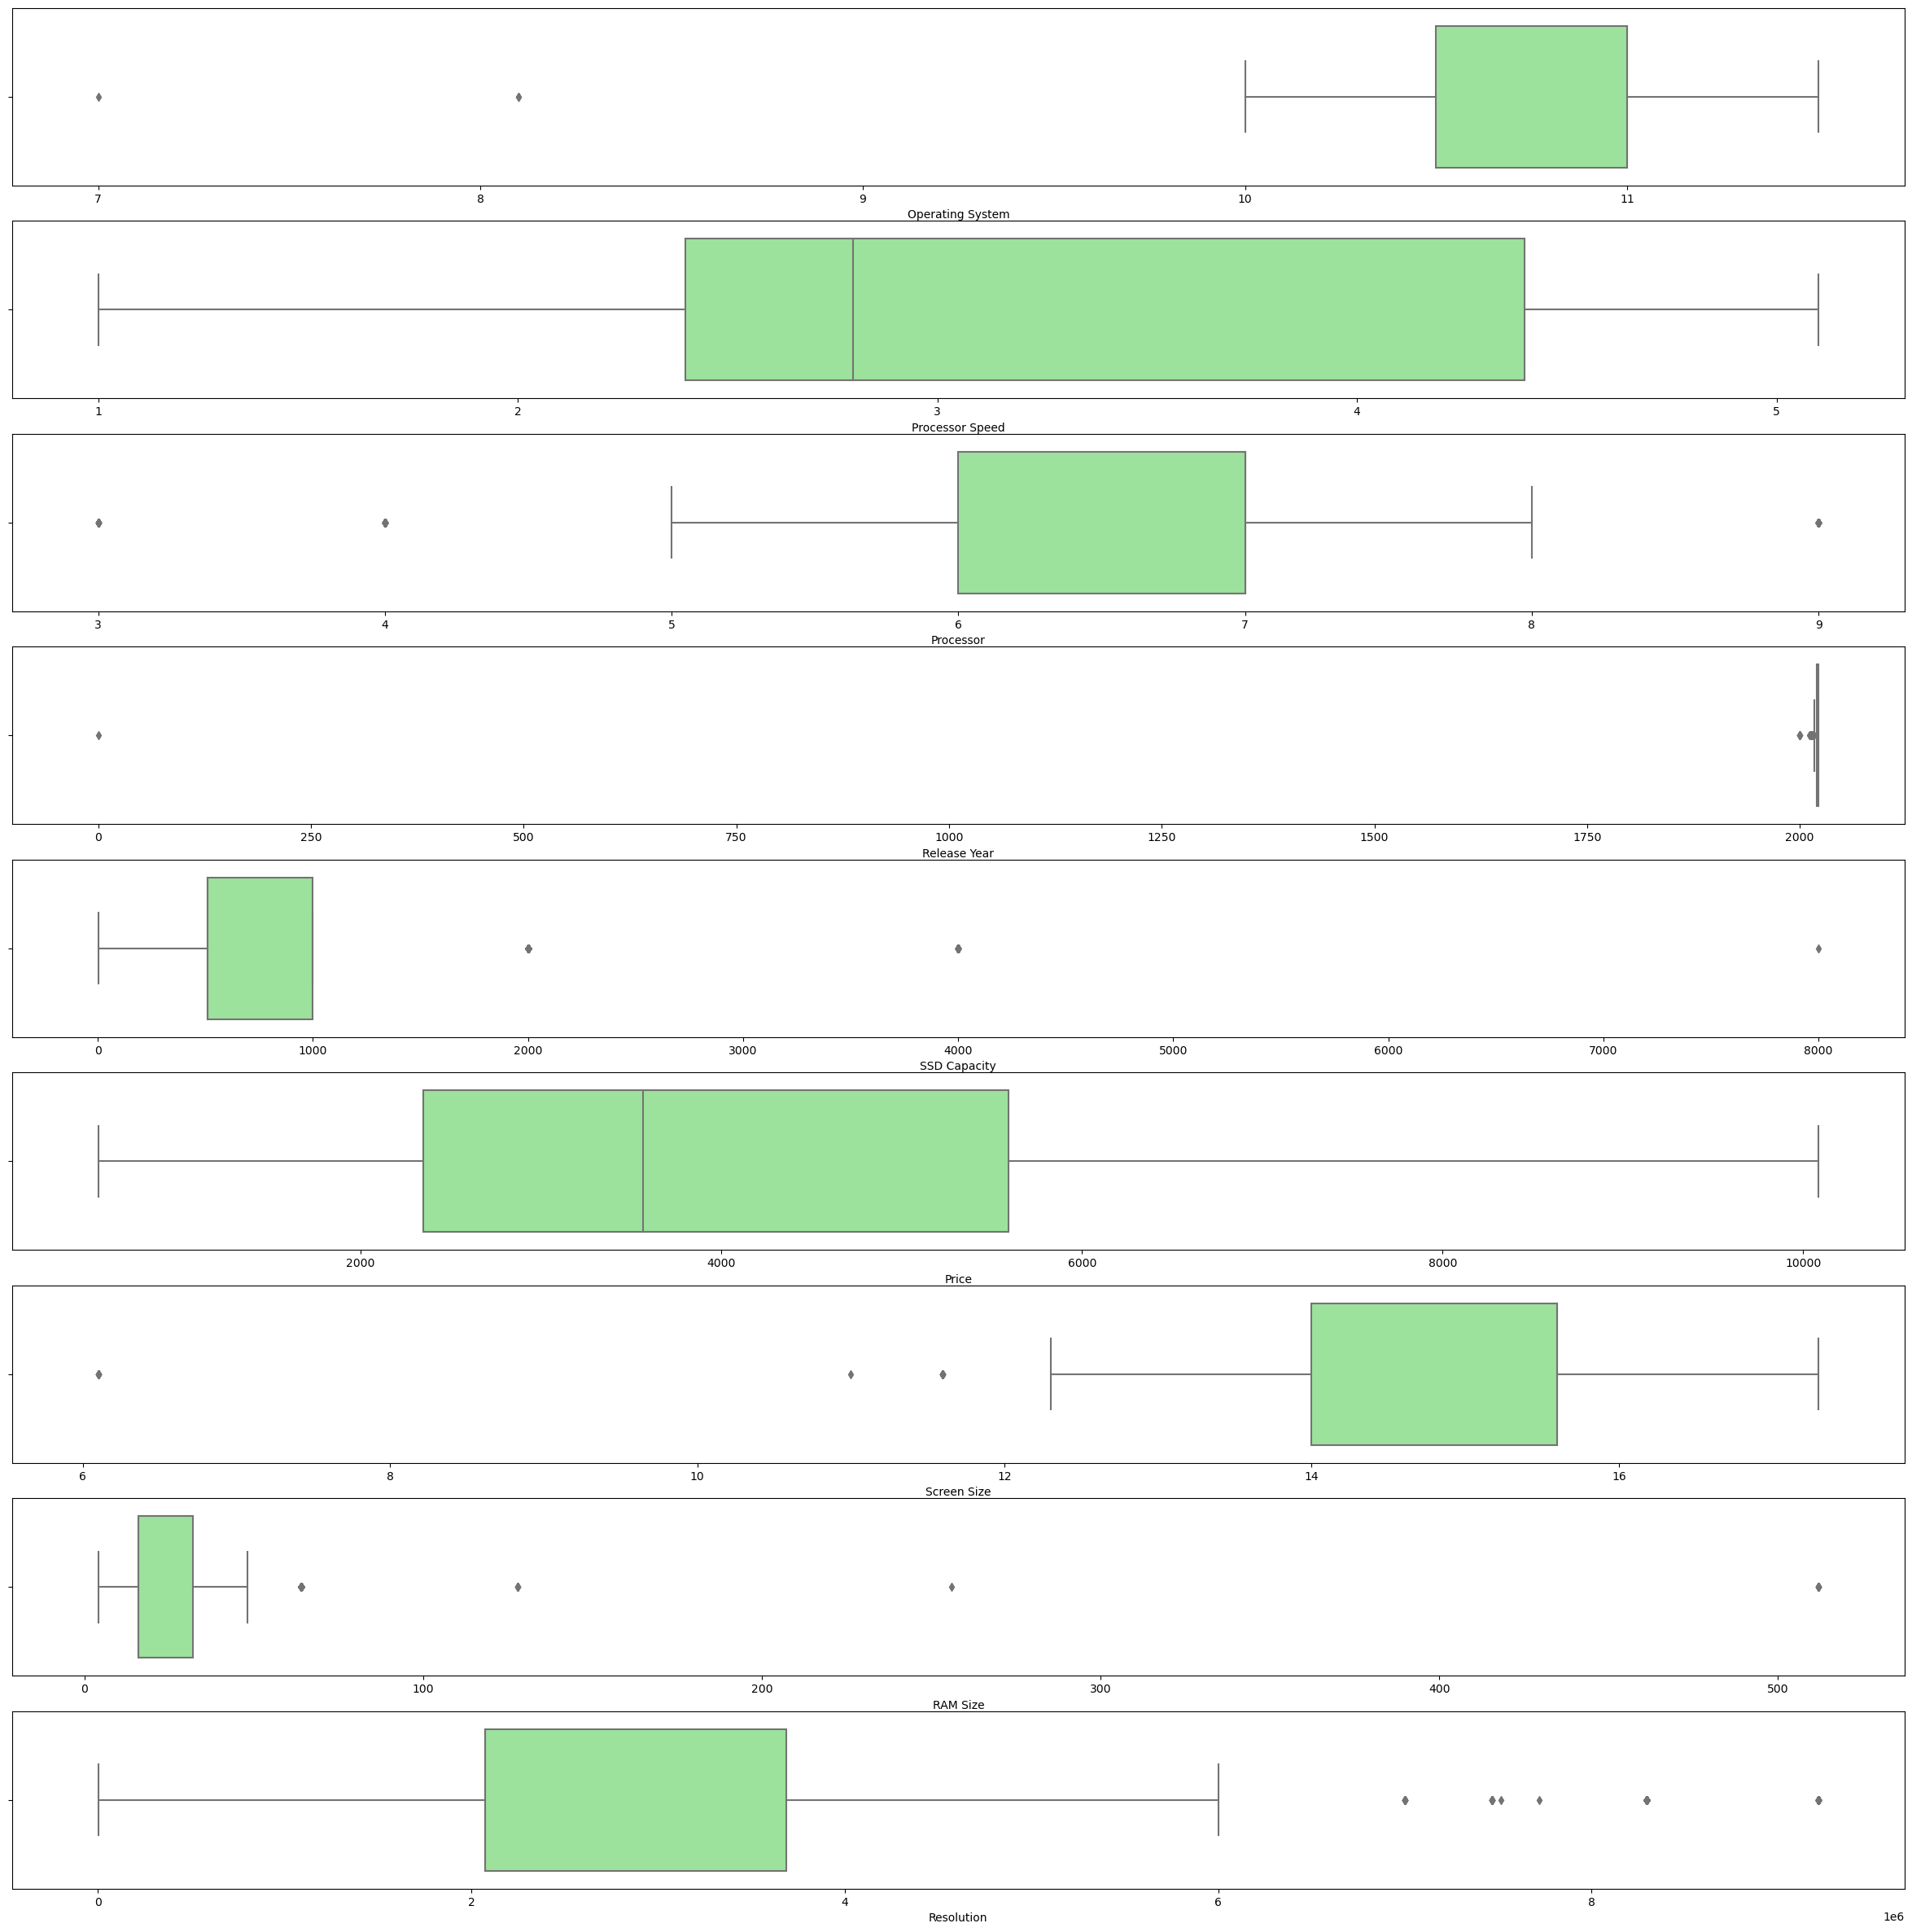

In [167]:
Numeric_Columns_list = ["Operating System" ,"Processor Speed" ,"Processor", "Release Year" , "SSD Capacity" ,"Price" , "Screen Size" , "RAM Size" , "Resolution"]

Numeric_Data = pd.DataFrame(DF,columns=Numeric_Columns_list)
fig, ax = plt.subplots(len(Numeric_Columns_list),1, figsize = (30,30))

for i , col in enumerate(Numeric_Columns_list):
    sns.boxplot(data = Numeric_Data, x = col, ax = ax[i], color = 'lightgreen')



In [168]:
def clean_Outlayers(df) :
    df.drop(df[df['Screen Size'] <= 12].index, inplace = True)
    df.drop(df[df['Release Year'] <= 2000].index, inplace = True)
   # df.drop(df[df['RAM Size'] >= 200].index, inplace = True)
   # df.drop(df[df['SSD Capacity'] > 1500].index, inplace = True)
    df.drop(df[df['Operating System'] < 9].index, inplace = True)
    
    
    return df


#### After cleaning outlayers:

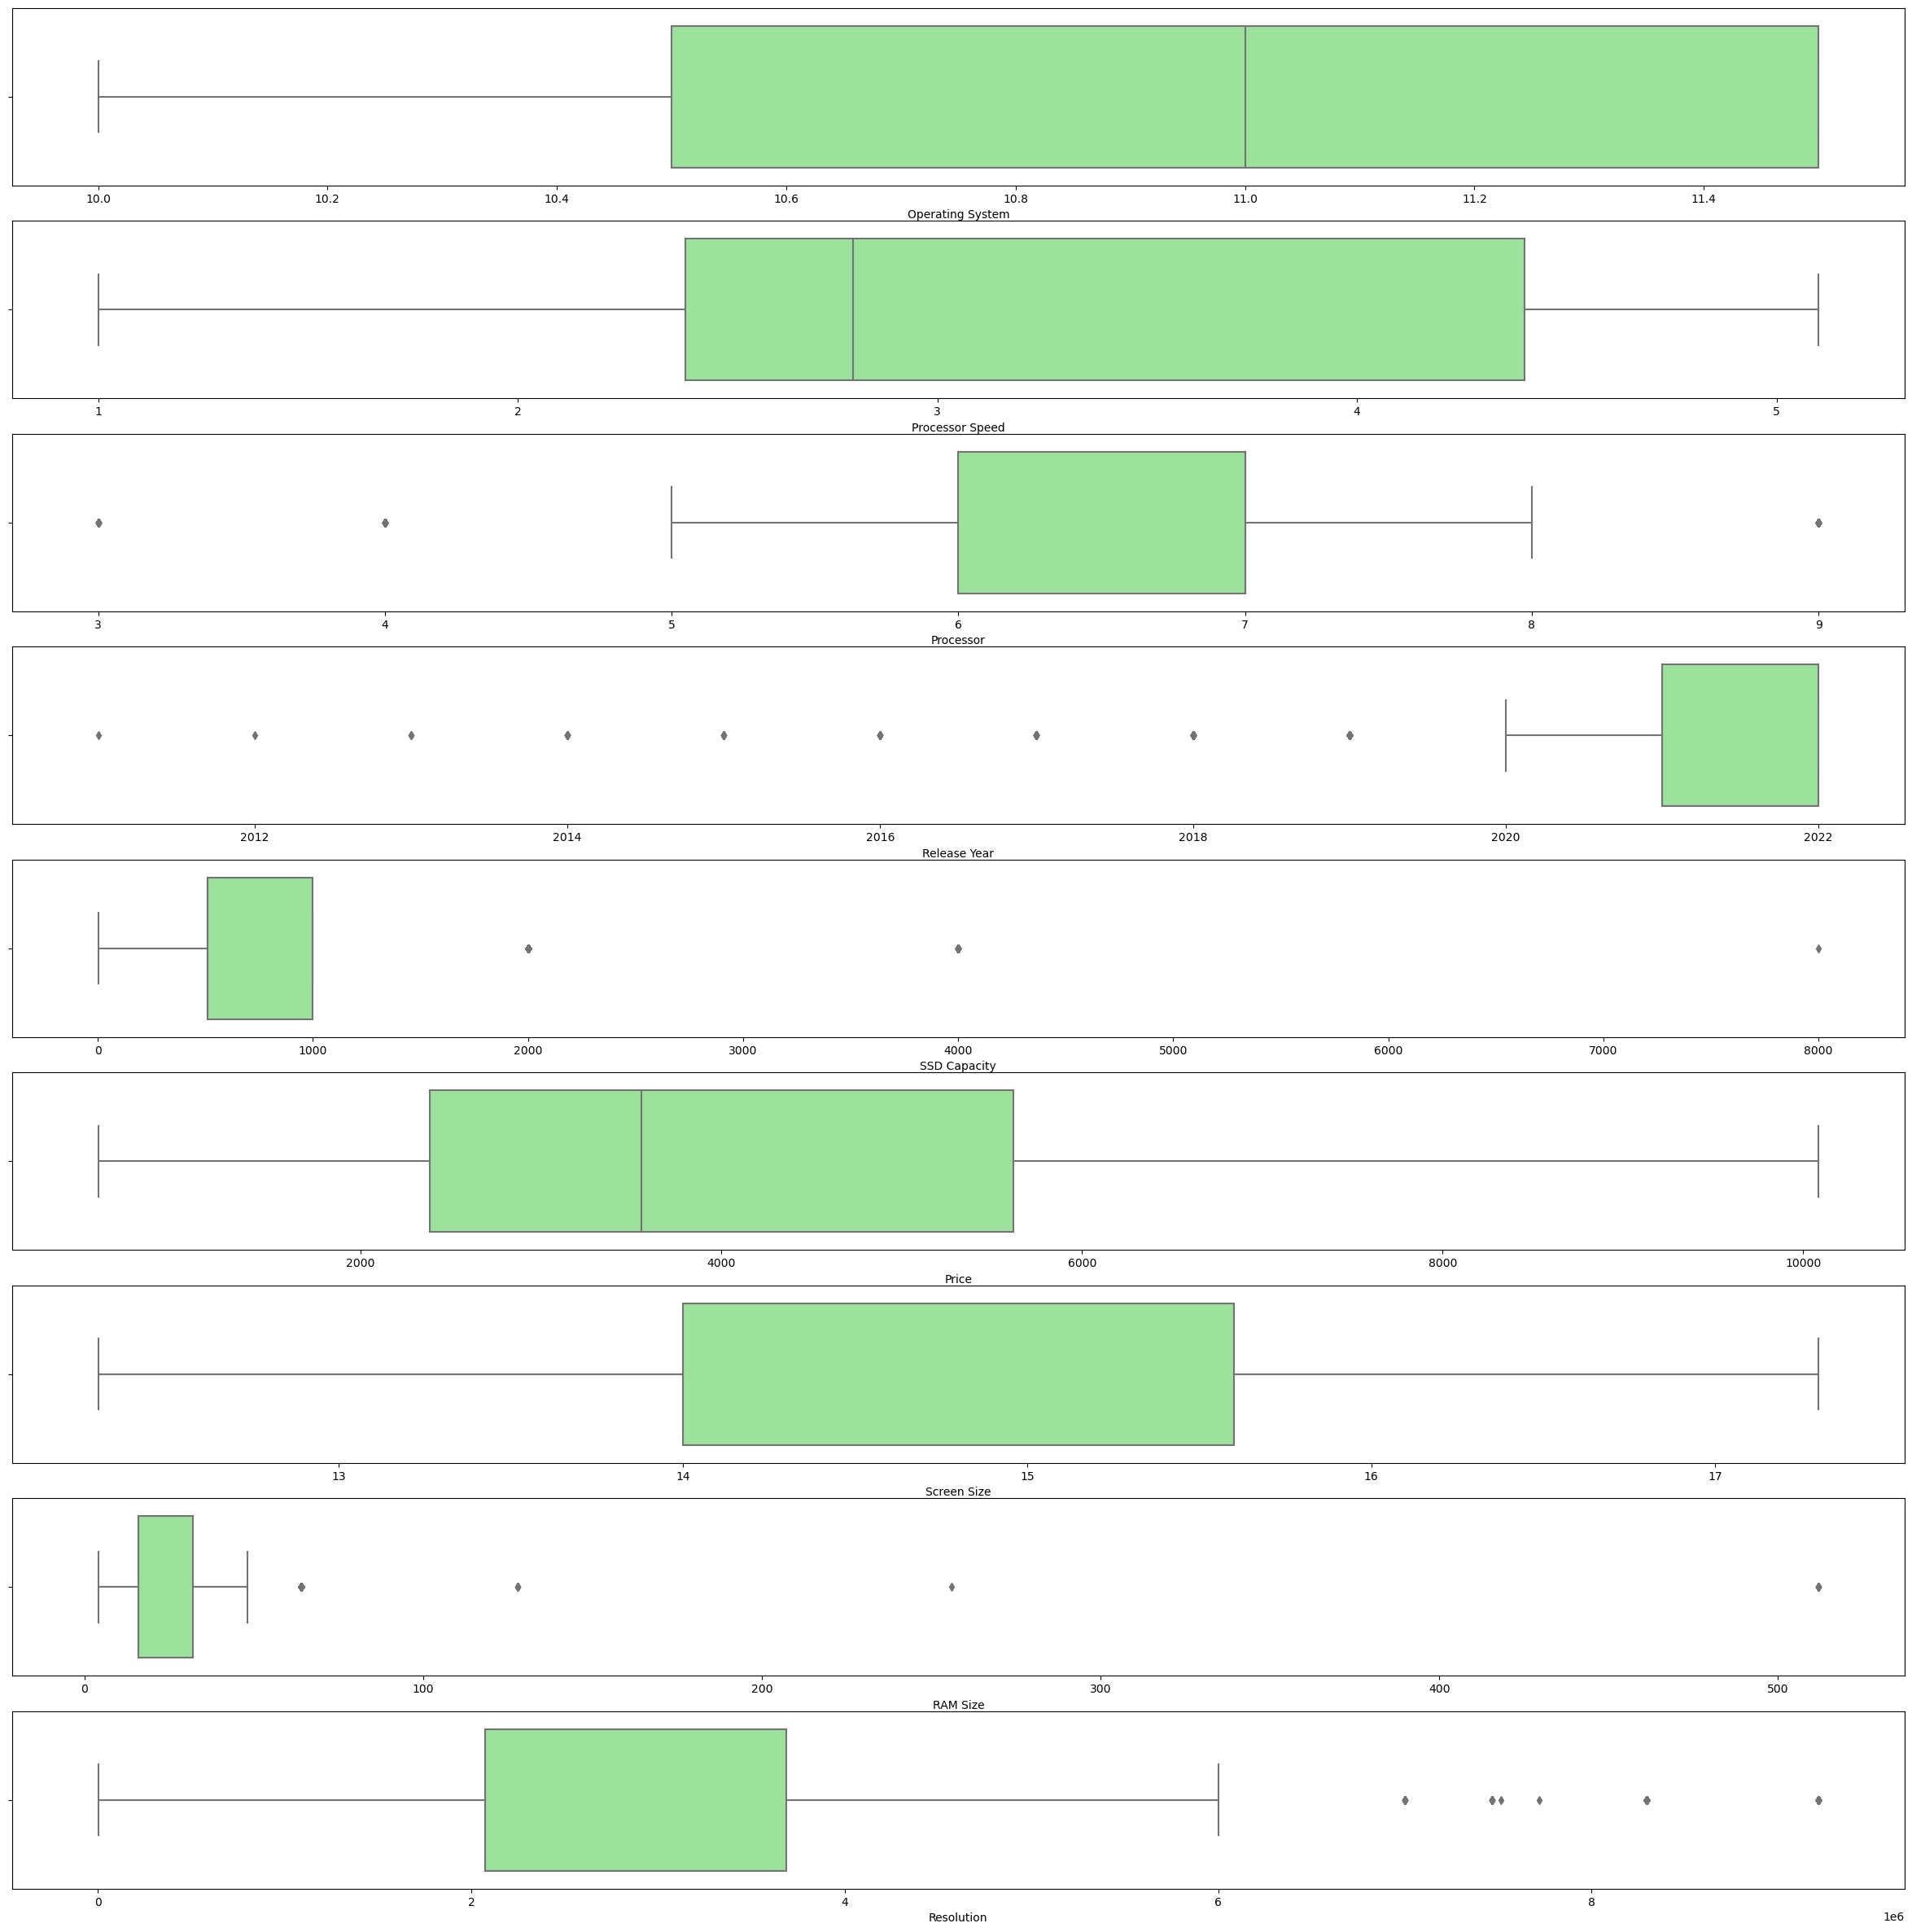

In [169]:
DF = clean_Outlayers(DF)
DF = DF.reset_index()
Numeric_Data = pd.DataFrame(DF,columns=Numeric_Columns_list)
fig, ax = plt.subplots(len(Numeric_Columns_list),1, figsize = (30,30))
for i , col in enumerate(Numeric_Columns_list):
    sns.boxplot(data = Numeric_Data, x = col, ax = ax[i], color = 'lightgreen')

#### Checking connections between each two numeric features.

Text(0.5, 1.0, 'Features Connections')

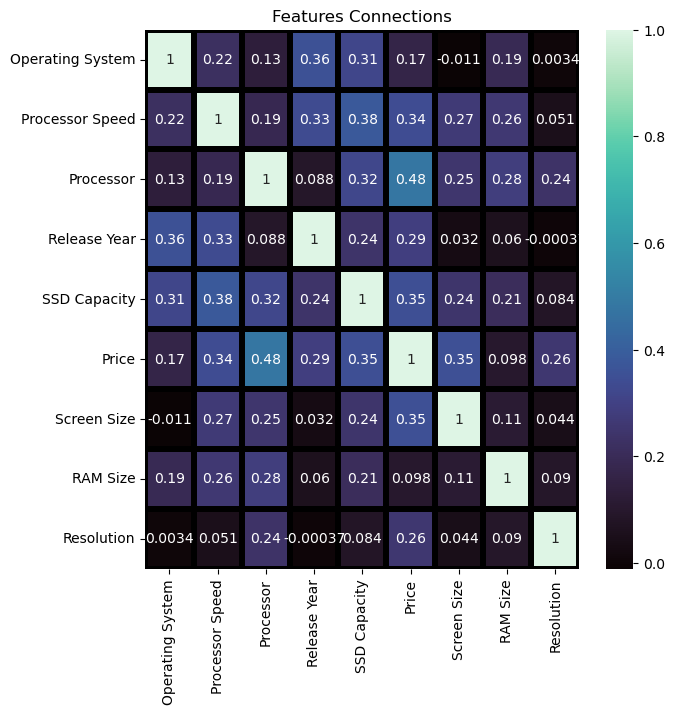

In [170]:
fig , axes = plt.subplots(figsize=(7,7))
sns.heatmap(Numeric_Data.corr(),cmap='mako', linewidth=3 , linecolor = "black" , annot=True , ax=axes)
axes.set_title('Features Connections')

#### Filling nan values by the most frequent value of the same price range.

In [171]:
def Fill_NaN_By_Frequent(df,col) :
    rows_size = df.shape[0]
    target_array = []
    for i in range(rows_size) :
        if pd.isna(df[col][i]) :
            num = df["Price"][i]
            for j in range(rows_size) :
                if df["Price"][j] < (num + 200) and df["Price"][j] > (num - 200) :
                    target_array.append(df[col][j])
            for k in range(len(target_array)) :
                if pd.isna(target_array[k]) :
                    target_array[k] = 0 ;
            freq = np.bincount(target_array).argmax()
            df[col][i] = freq
            
    return df  

In [172]:
Fill_By_Frequent = ["Operating System" ,"Processor Speed" ,'Processor' , "Release Year" , "SSD Capacity" , "Screen Size" , "RAM Size" , "Resolution"]

for col in Fill_By_Frequent:
    DF = Fill_NaN_By_Frequent(DF,col)


C:\Users\שלומי\AppData\Local\Temp\ipykernel_3744\1318060534.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = freq


#### Checking if we filled all nan successfully

In [173]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     2062 non-null   int64  
 1   Operating System          2062 non-null   float64
 2   Graphics Processing Type  2062 non-null   object 
 3   Processor Speed           2062 non-null   float64
 4   Color                     2062 non-null   object 
 5   GPU                       2062 non-null   object 
 6   Release Year              2062 non-null   float64
 7   Brand                     2062 non-null   object 
 8   Processor                 2062 non-null   float64
 9   SSD Capacity              2062 non-null   float64
 10  Price                     2062 non-null   float64
 11  Screen Size               2062 non-null   float64
 12  RAM Size                  2062 non-null   float64
 13  Resolution                2062 non-null   float64
dtypes: float

#### Cheking connections between each numeric feature to price by scatterplots

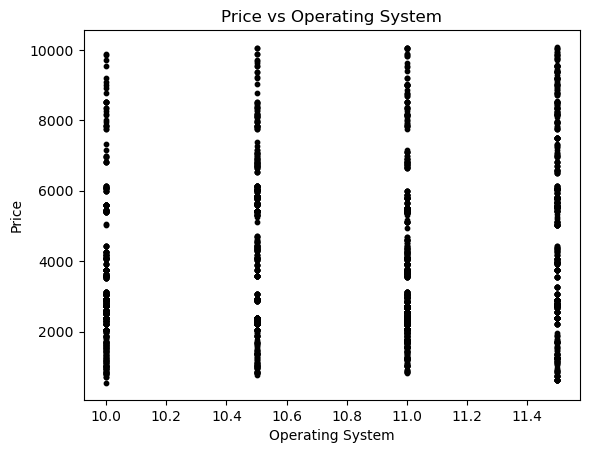

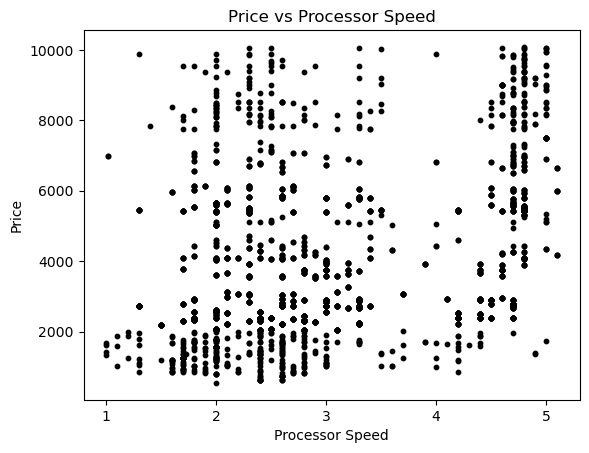

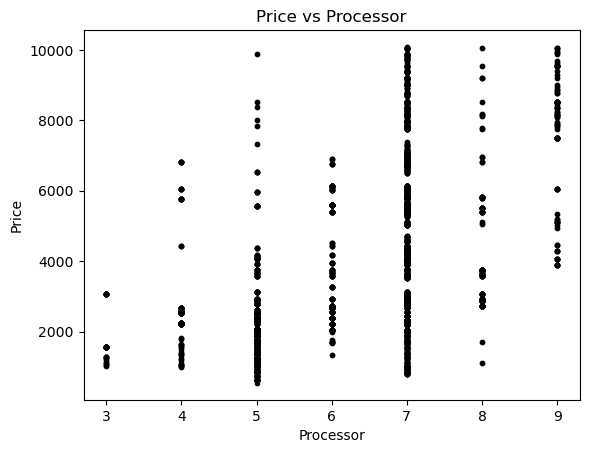

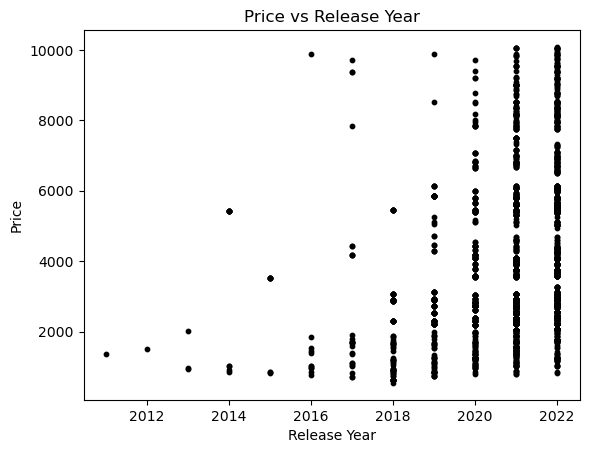

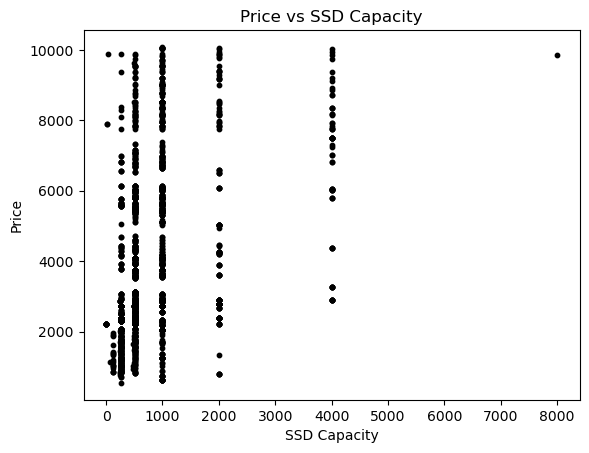

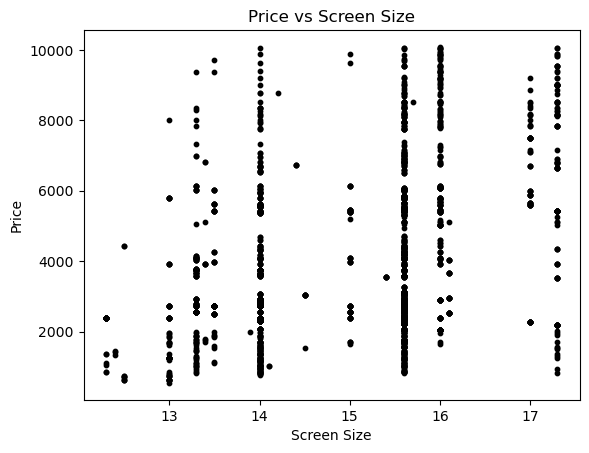

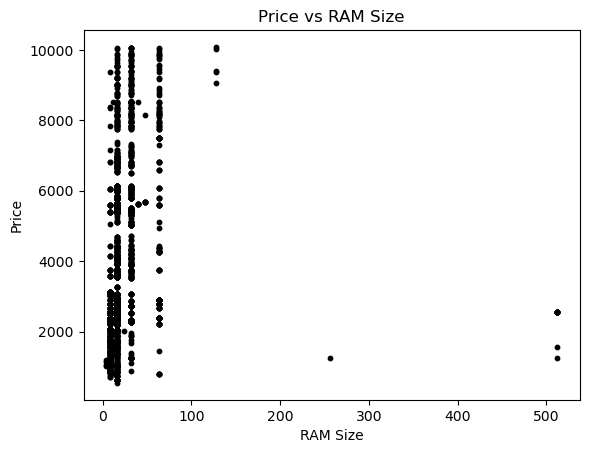

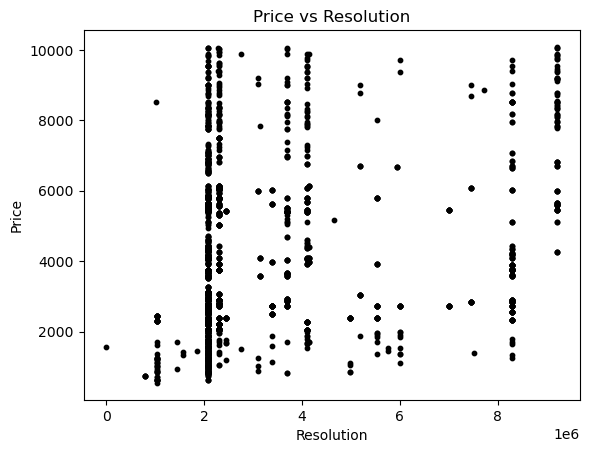

In [174]:

Numeric_Col_list = ["Operating System" ,"Processor Speed" , "Processor", "Release Year" , "SSD Capacity"  , "Screen Size" , "RAM Size" , "Resolution"]
for i in range(len(Numeric_Col_list)) :
    DF.plot.scatter(x = Numeric_Col_list[i], y = 'Price', s = 10 , c = 'black').set(title = 'Price vs ' + Numeric_Col_list[i])


Text(0.5, 1.0, 'Features Connections')

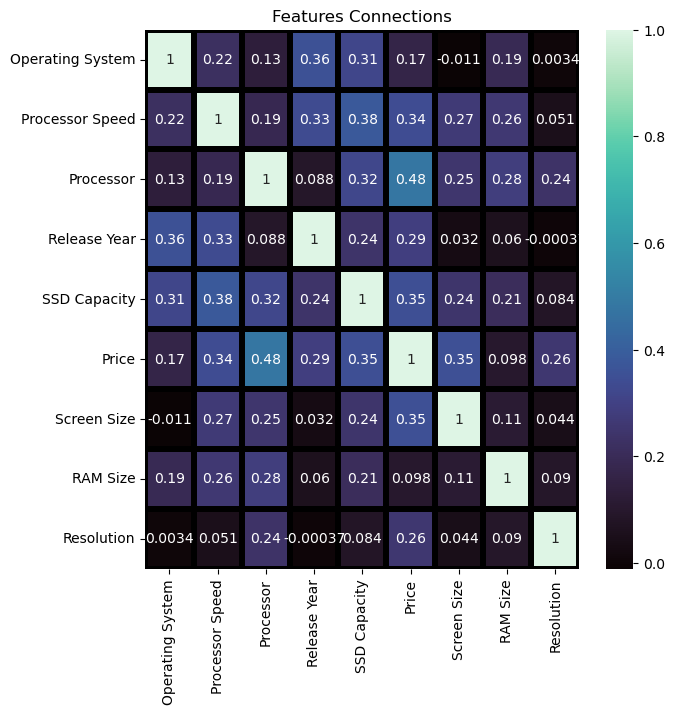

In [175]:
fig , axes = plt.subplots(figsize=(7,7))
sns.heatmap(Numeric_Data.corr(),cmap='mako', linewidth=3 , linecolor = "black" , annot=True , ax=axes)
axes.set_title('Features Connections')

#### Checking connections between each two features to price by 3D plots.

In [176]:
def Create_Scatter3D(col1 , col2 , df) :
    ax = plt.axes(projection='3d')
    xdata = df[col1]
    ydata = df[col2]
    zdata = df["Price"]

    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_zlabel('Price')
    ax.scatter3D(xdata,ydata,zdata , c=zdata , depthshade=False)
    plt.show()

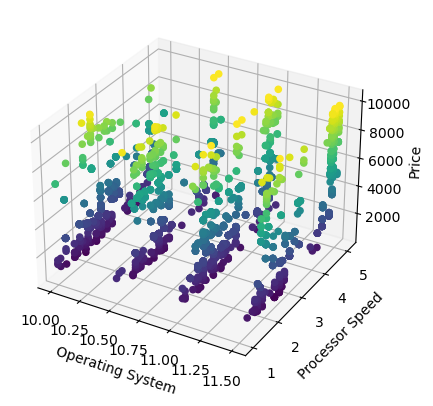

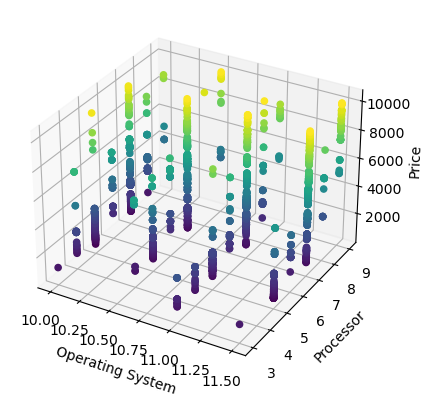

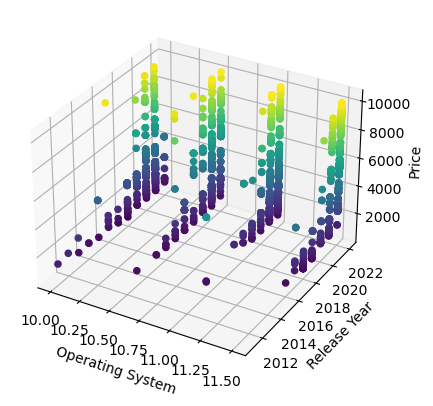

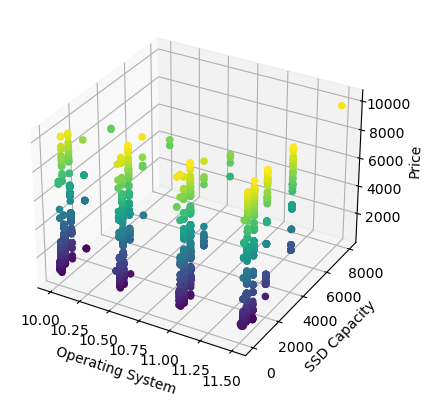

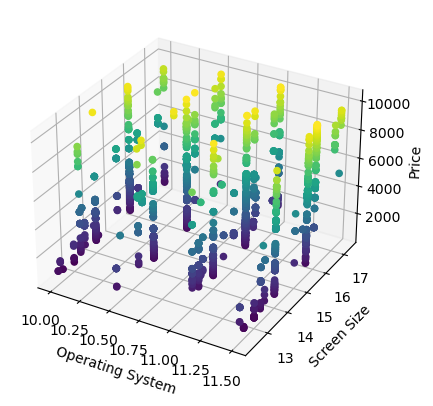

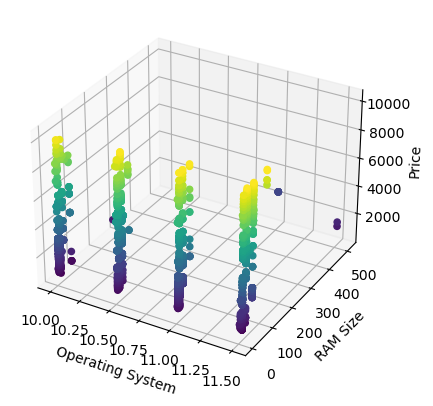

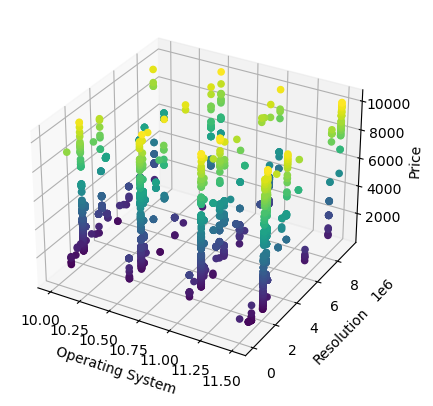

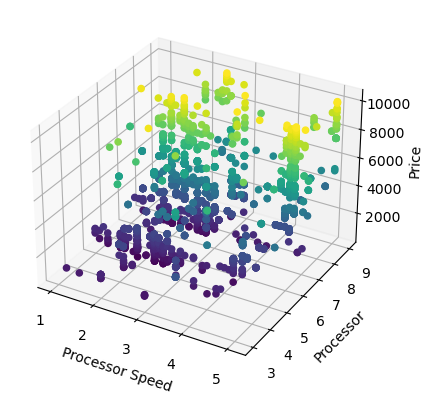

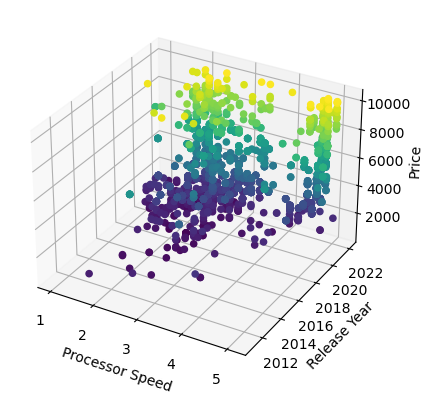

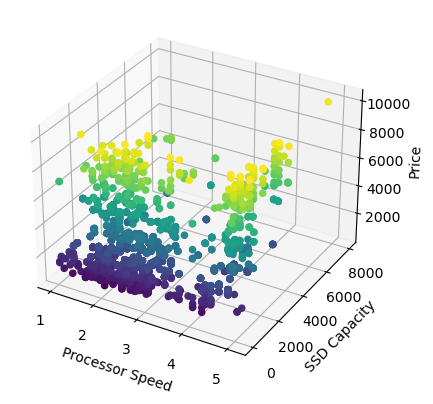

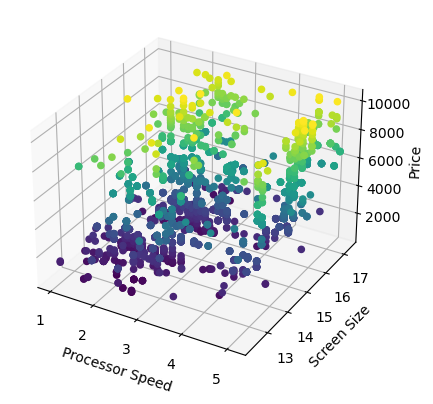

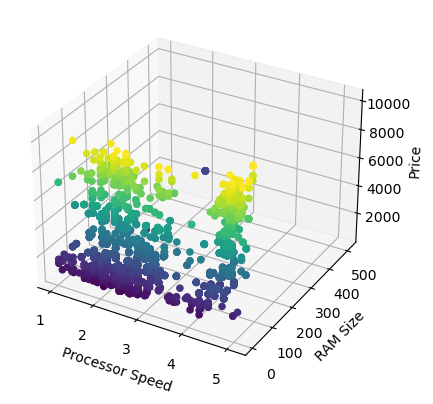

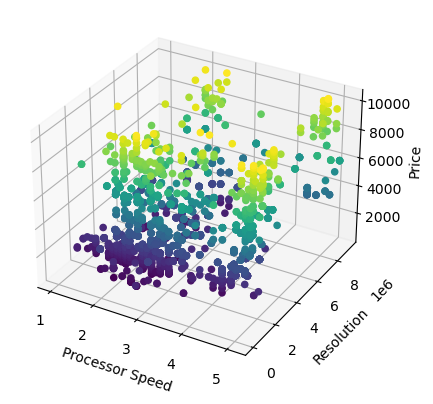

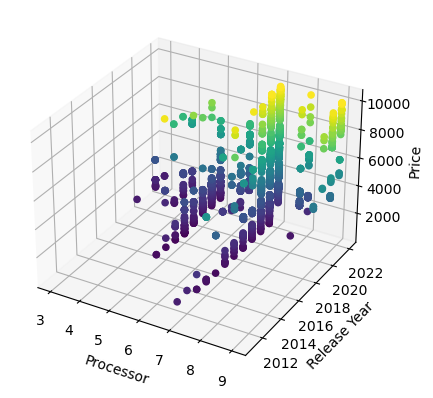

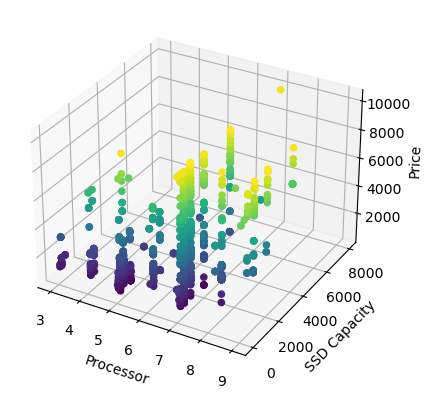

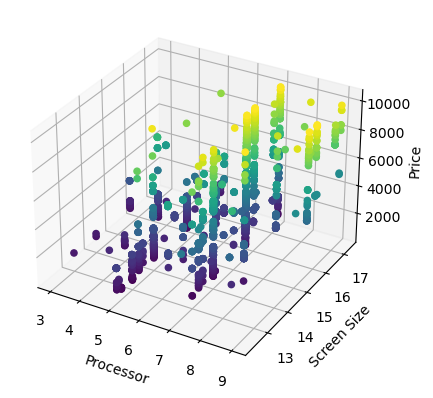

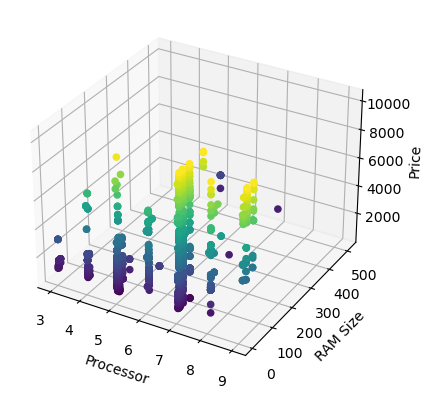

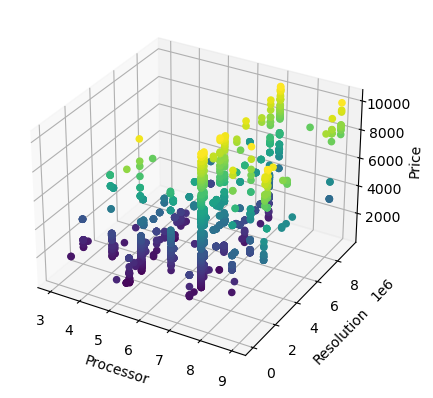

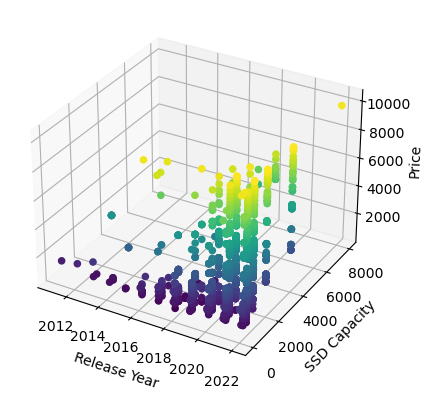

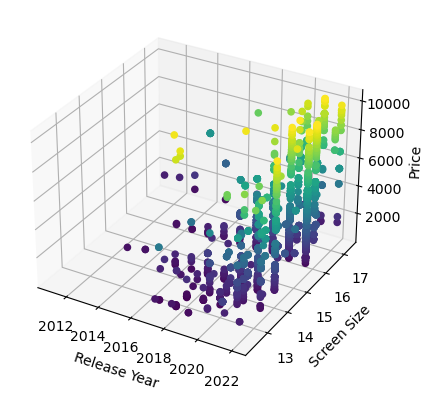

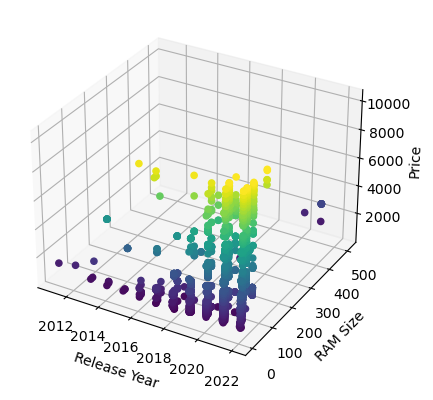

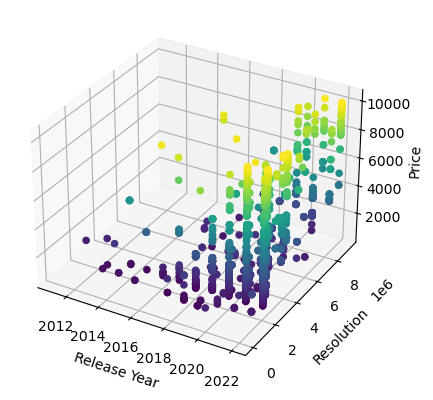

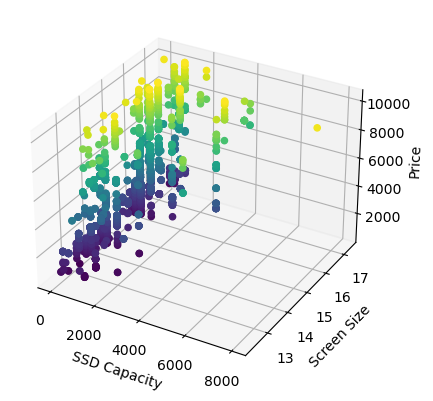

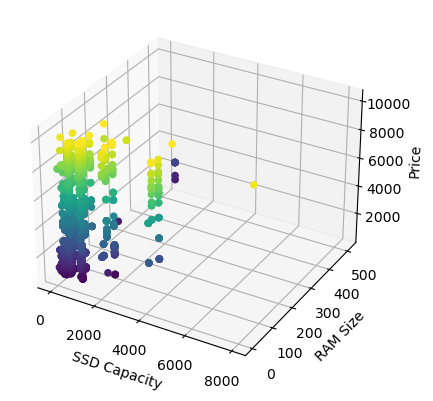

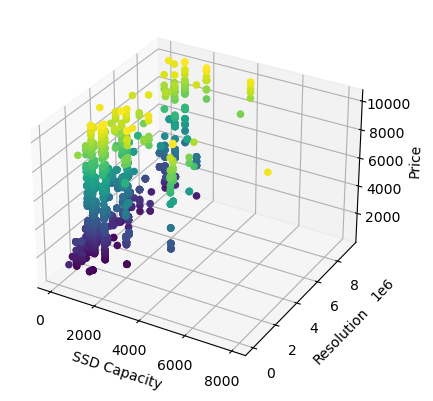

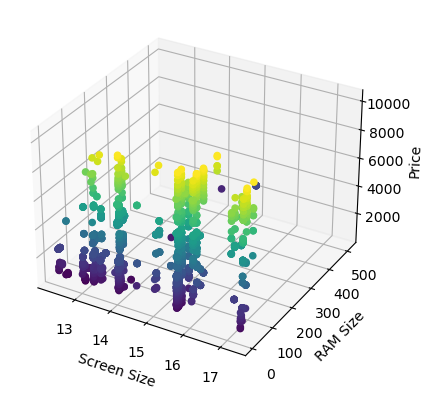

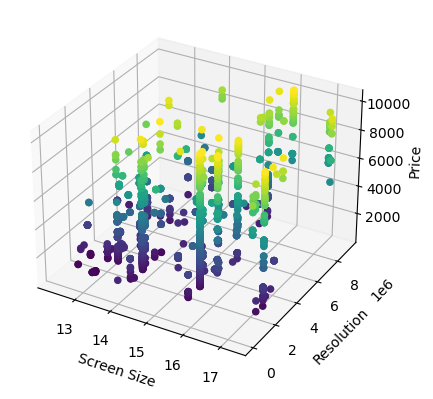

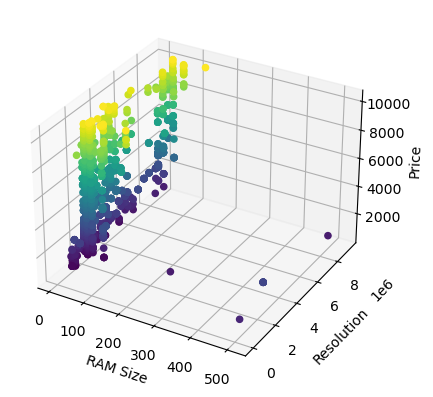

In [177]:
Numeric_Col_list = ["Operating System" ,"Processor Speed" ,"Processor", "Release Year" , "SSD Capacity"  , "Screen Size" , "RAM Size" , "Resolution"]
count = 0
for i in range(len(Numeric_Col_list)) :
    for j in range(len(Numeric_Col_list)) :
        if(i<j) :
            Create_Scatter3D(Numeric_Col_list[i] , Numeric_Col_list[j] , DF)


In [178]:
#DF.to_csv("DataFrame_After_Clean.csv", header = True , index = False)

DataFrame = pd.read_csv("DataFrame_After_Clean.csv")



#### Label Encoding the non numeric columns. 

In [179]:
DataFrame = pd.get_dummies(DataFrame , columns =['Graphics Processing Type'])

Non_Numeric_list = [ "Color" , "GPU" , "Brand"]

le = LabelEncoder()
    
for col in Non_Numeric_list:
    DataFrame[col] = le.fit_transform(DataFrame[col])

DataFrame

,Operating System,Processor Speed,Color,GPU,Release Year,Brand,Processor,SSD Capacity,Price,Screen Size,RAM Size,Resolution,Graphics Processing Type_Dedicated,Graphics Processing Type_Integrated
0,10.0,3.0,3,61,2021,7,5,256.0,1018.69,15.6,8,2073600,0,1
1,10.0,2.8,13,57,2020,18,7,512.0,953.96,14.0,16,2073600,0,1
2,10.0,2.4,13,108,2021,20,7,1000.0,885.82,15.6,16,2073600,1,0
3,10.5,1.6,36,48,2018,14,5,256.0,882.41,14.0,8,2073600,0,1
4,10.5,1.9,36,61,2020,14,7,512.0,971.00,14.0,16,2073600,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2057,11.5,4.7,3,140,2022,18,7,4000.0,9863.28,16.0,32,9216000,1,0
2058,11.5,4.8,3,138,2022,18,7,8000.0,9863.28,16.0,64,2304000,1,0
2059,11.5,5.0,3,140,2022,18,9,4000.0,9948.45,16.0,32,2304000,1,0
2060,11.5,4.8,3,138,2022,18,7,4000.0,10013.19,16.0,128,2304000,1,0


#### We chose the target column(Price) and we used the train test split function.

In [180]:
Training_Features = DataFrame.columns[DataFrame.columns != "Price" ]
Target_Feature   = "Price"

X = DataFrame[Training_Features]
Y = DataFrame[Target_Feature]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


In [181]:
X

,Operating System,Processor Speed,Color,GPU,Release Year,Brand,Processor,SSD Capacity,Screen Size,RAM Size,Resolution,Graphics Processing Type_Dedicated,Graphics Processing Type_Integrated
0,10.0,3.0,3,61,2021,7,5,256.0,15.6,8,2073600,0,1
1,10.0,2.8,13,57,2020,18,7,512.0,14.0,16,2073600,0,1
2,10.0,2.4,13,108,2021,20,7,1000.0,15.6,16,2073600,1,0
3,10.5,1.6,36,48,2018,14,5,256.0,14.0,8,2073600,0,1
4,10.5,1.9,36,61,2020,14,7,512.0,14.0,16,2073600,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2057,11.5,4.7,3,140,2022,18,7,4000.0,16.0,32,9216000,1,0
2058,11.5,4.8,3,138,2022,18,7,8000.0,16.0,64,2304000,1,0
2059,11.5,5.0,3,140,2022,18,9,4000.0,16.0,32,2304000,1,0
2060,11.5,4.8,3,138,2022,18,7,4000.0,16.0,128,2304000,1,0


In [182]:
Y

0        1018.69
1         953.96
2         885.82
3         882.41
4         971.00
          ...   
2057     9863.28
2058     9863.28
2059     9948.45
2060    10013.19
2061    10084.73
Name: Price, Length: 2062, dtype: float64

#### Trying Linear Regression

In [186]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

regressor = LinearRegression()
regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
print('R-squared score: {:.2f}'.format(r2))


R-squared score: 0.53


#### Trying Decision Tree

In [196]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

regressor = DecisionTreeRegressor(max_depth=10) 
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R-squared score: {:.2f}'.format(r2))


R-squared score: 0.72


#### Trying KNN

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train) 

y_pred = knn_reg.predict(X_test) 
r2 = r2_score(y_test, y_pred) 
print('R-squared score: {:.2f}'.format(r2))

R-squared score: 0.66


#### Using Random Forest

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

regressor = RandomForestRegressor(n_estimators=100, max_depth=13, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R-squared score: {:.2f}'.format(r2))


R-squared score: 0.80


In [190]:
print('R2 on train set : ' ,regressor.score(X_train,y_train))
print('R2 on test set : ' ,regressor.score(X_test,y_test))

MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

print("RMSE : ",RMSE)



R2 on train set :  0.9652792354009446
R2 on test set :  0.803681049061463
RMSE :  1032.797986836373


#### Creating a dataframe with Correct price(y test) and Predicted price(y pred)

In [191]:
Predict_Result = pd.DataFrame({"Correct Price" : y_test , "Predicted Price" : y_pred})
Predict_Result["Predicted difference"] = abs(Predict_Result["Correct Price"] - Predict_Result["Predicted Price"])
Predict_Result

,Correct Price,Predicted Price,Predicted difference
942,4183.59,4236.721962,53.131962
1510,5570.45,5648.200376,77.750376
1527,5025.33,5034.088577,8.758577
1682,6814.01,3169.228158,3644.781842
1900,8173.40,8357.014447,183.614447
...,...,...,...
1893,8124.04,6329.312443,1794.727557
905,2381.50,2369.404755,12.095245
1501,4258.76,4285.316122,26.556122
19,626.92,667.703498,40.783498


#### Here we can see the correlation between the correct price to the predicted price.

Text(0.5, 0, 'Correct Price')

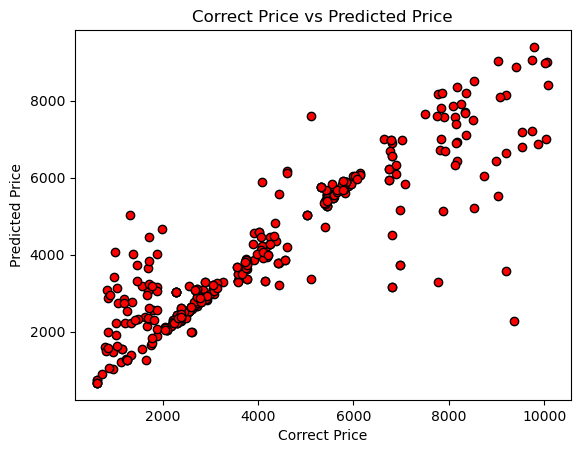

In [192]:
plt.scatter(Predict_Result["Correct Price"] , Predict_Result['Predicted Price'], color = 'red' , edgecolors = 'black')
plt.title("Correct Price vs Predicted Price")
plt.ylabel("Predicted Price")
plt.xlabel("Correct Price")


Text(0.5, 0, 'Computer Index In DataFrame')

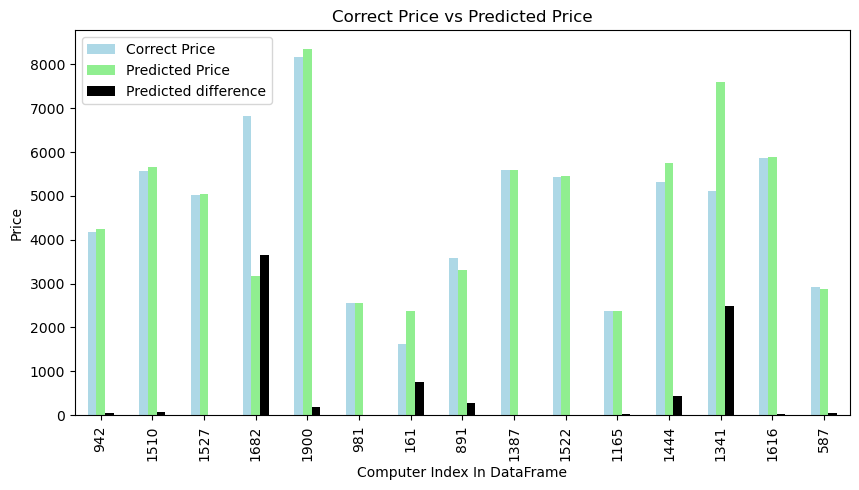

In [193]:
Predict_Result.head(15).plot(kind = 'bar' , figsize = (10,5) , color= ['lightblue' , 'lightgreen' , 'black'])
plt.title("Correct Price vs Predicted Price")
plt.ylabel("Price")
plt.xlabel("Computer Index In DataFrame")

